In [1]:
# MA Cross Backtesting on 1H BTC with following trade costs and timeframes
# - Slippage is 0.5BPS
# - Taker fee is 0.05%
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/crypto-spot/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)

df_

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2024-01-31 23:55:00,42611.31,42614.98,42607.91,42614.98,8.673160
2024-01-31 23:56:00,42614.98,42617.80,42610.55,42617.80,4.741770
2024-01-31 23:57:00,42617.80,42617.80,42617.79,42617.80,1.950260


<Axes: xlabel='date'>

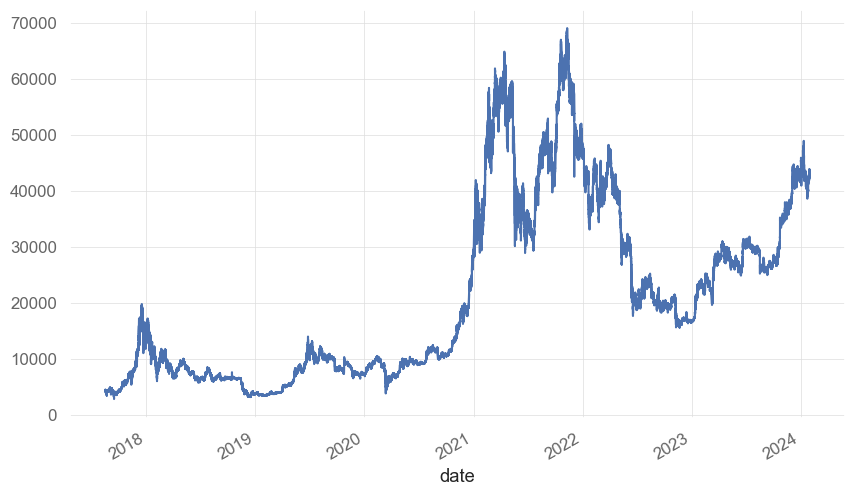

In [4]:
df_['Close'].plot()

In [5]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df['Price'] = df['Open'].shift(-1)
df.dropna(inplace=True)

df

,Open,High,Low,Close,Volume,Price
date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,4308.83
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,4315.32
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,4324.35
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,4333.32
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4360.69
...,...,...,...,...,...,...
2024-01-31 18:00:00,43715.04,43745.11,43474.13,43513.38,1499.795790,43513.38
2024-01-31 19:00:00,43513.38,43551.99,43041.10,43334.64,2549.594580,43334.63
2024-01-31 20:00:00,43334.63,43361.10,42519.92,42541.18,3928.704250,42541.19


In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    55116
 1      670
-1      670
Name: count, dtype: int64

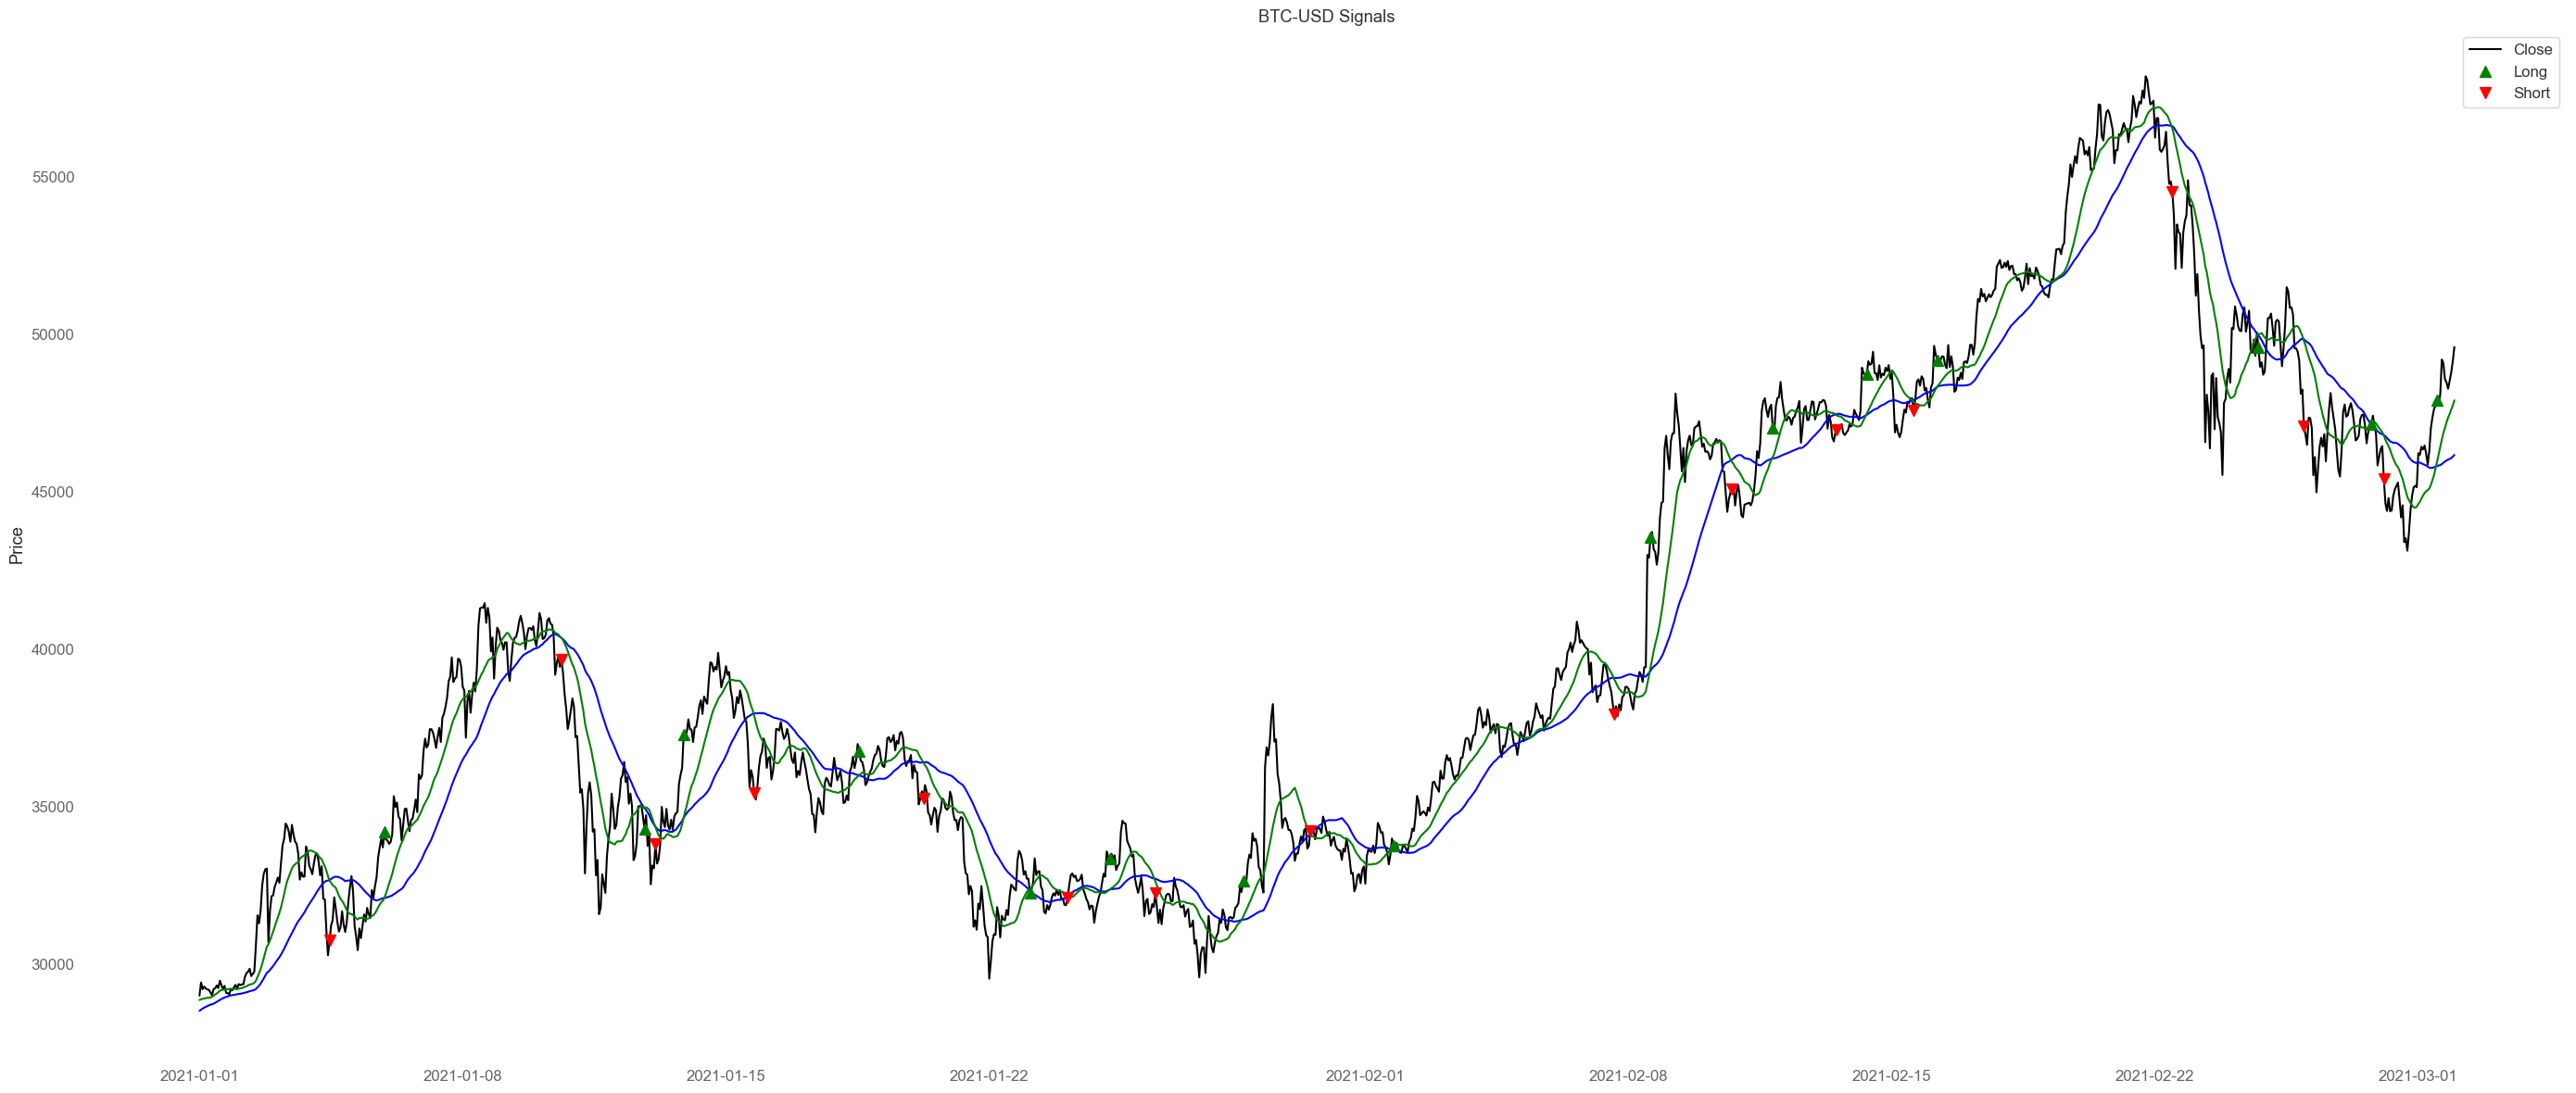

In [8]:
plot_df = df["2021-01-01":"2021-03-01"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Price'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Price'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [9]:
# Position tracking with slippage

slippage_bps     = 0.5 / 10000 # 0.5BPS
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Price'] * (1 - slippage_bps) if position == 1 else row['Price'] * (1 + slippage_bps)
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Price'] * (1 + slippage_bps)
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Price'] * (1 - slippage_bps)
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [10]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.05    # 0.05% commission fee per trade
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [11]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2017-08-20 13:00:00,2017-08-20 14:00:00,4063.553168,4096.115184,0.801319,0.801319,160.163765,10160.163765,NaN
2017-08-21 12:00:00,2017-08-21 13:00:00,3999.800000,3914.785730,-2.125463,-1.324144,-432.002652,9728.161113,-0.042519
2017-08-23 03:00:00,2017-08-23 04:00:00,4084.744227,4083.795800,-0.023219,-1.347363,-4.614799,9723.546314,-0.000474
2017-08-26 14:00:00,2017-08-26 15:00:00,4273.786300,4275.213750,0.033400,-1.313963,6.398118,9729.944432,0.000658
2017-08-27 11:00:00,2017-08-27 12:00:00,4323.586168,4313.894294,-0.224163,-1.538126,-43.719141,9686.225291,-0.004493
...,...,...,...,...,...,...,...,...
2024-01-26 04:00:00,2024-01-26 05:00:00,40147.242538,40104.405120,-0.106701,-4.606181,-16.269789,7572.196425,-0.002144
2024-01-26 11:00:00,2024-01-26 12:00:00,41291.584476,41137.953000,-0.372065,-4.978246,-56.422686,7515.773738,-0.007451
2024-01-29 10:00:00,2024-01-29 11:00:00,42311.064341,42249.062348,-0.146538,-5.124784,-22.102160,7493.671579,-0.002941


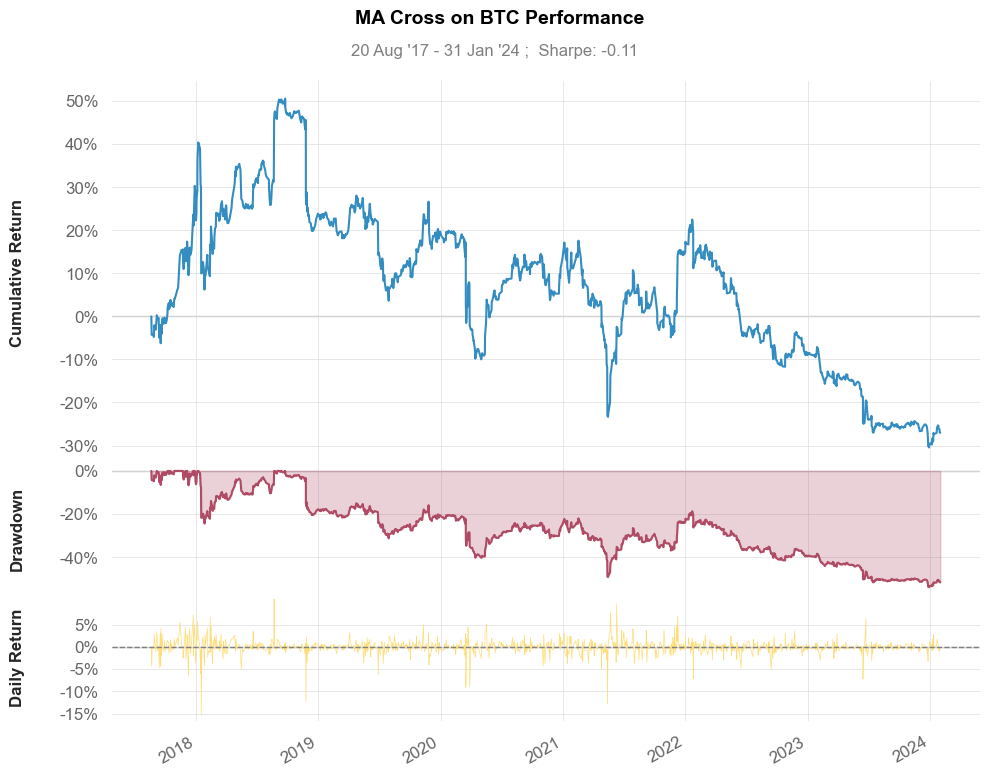

In [12]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

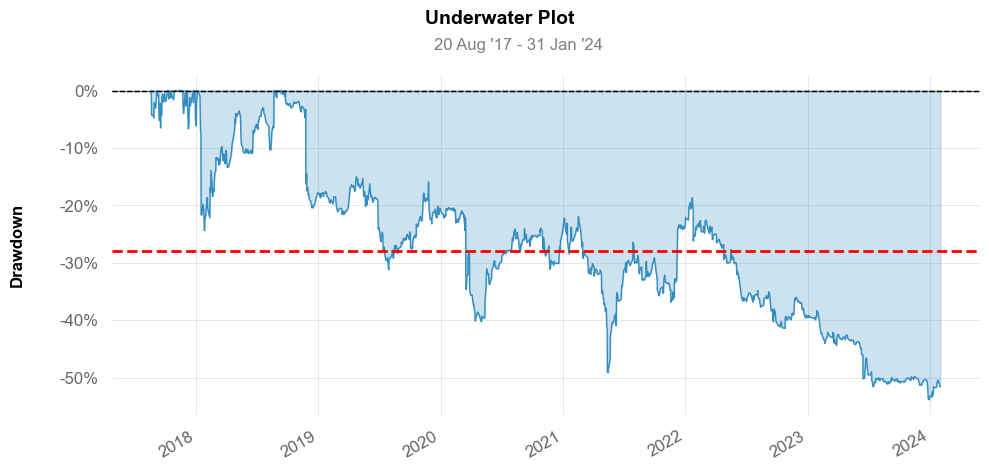

In [13]:
qs.plots.drawdown(position_df['Account Change'])

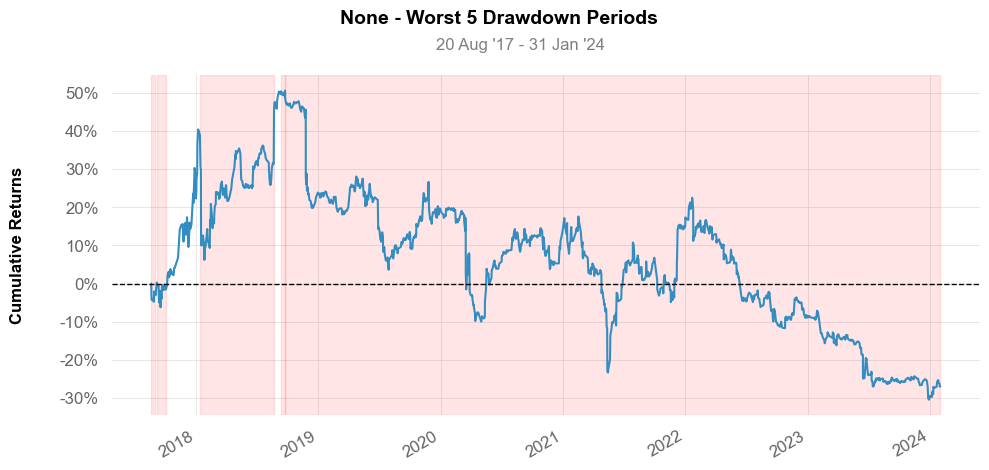

In [14]:
qs.plots.drawdowns_periods(position_df['Account Change'])

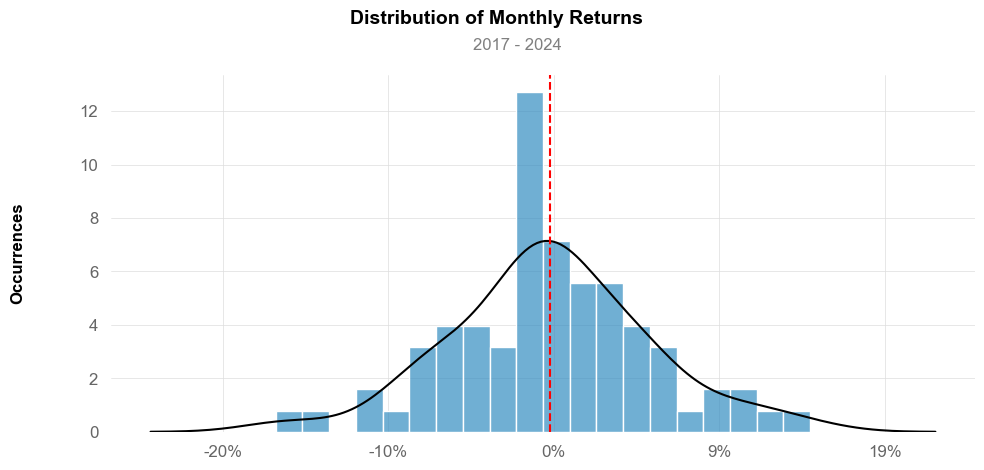

In [15]:
qs.plots.histogram(position_df['Account Change'])

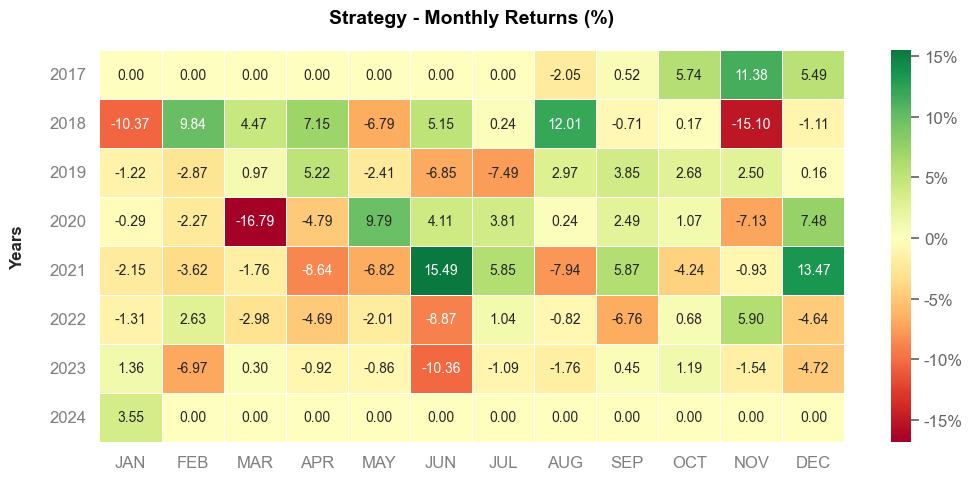

In [16]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [17]:
qs.stats.sharpe(position_df['Account Change'])

-0.10594404268133756

<Axes: xlabel='Entry Time'>

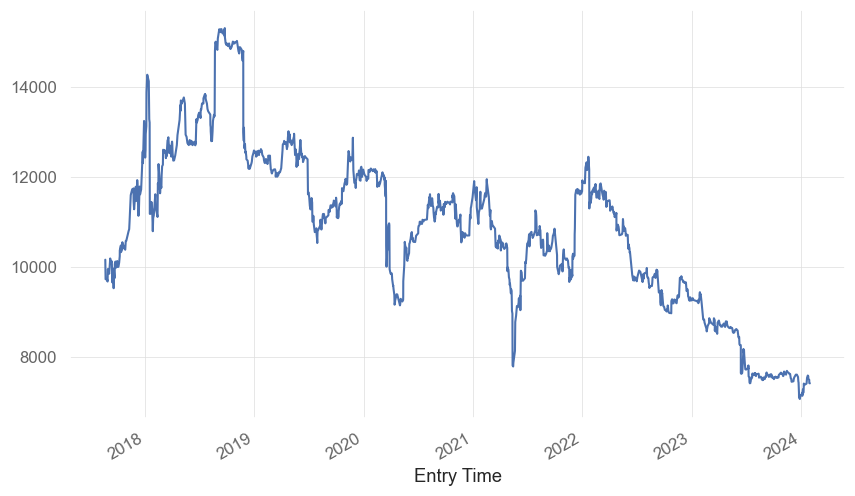

In [18]:
position_df["Account History"].plot()